# Guía 03 - Regresión con series temporales

Continuaremos nuestro estudio de caso empleando los datos de demanda eléctrica diaria obtenidos del sitio de Cammesa. Ahora, evaluaremos dos modelos. El primero realizará sus predicciones en base a los valores registrados previamente de demanda eléctrica. El segundo sumará variables exógenas  (temperatura media y el tipo de jornada). Introducieremos el esquema de validación cruzada para luego hallar un conjunto de parámetros con los que el modelo logra la mejor respuesta. Esta mejor respuesta siempre requiere de algún tipo de función que compare y cuantifique el acuerdo entre los valores observados (valores en el paso/s siguiente/s o respuestas) y los predecidos por el modelo. Finalmente, se debe informar sobre la calidad del modelo teniendo presente que la evaluación deberá realizarse sobre un conjunto de datos independientes de los que participaron en la calibración.

## Parte A - Modelo de regresión que solo usa los valores registrados previamente

Nos proponemos realizar predicciones para la demanda eléctrica total (`DEMANDA TOTAL`) tomando solamente los valores registrados en fechas previas a la que se busca pronosticar. La idea detrás de este abordaje es que la predicción en un tiempo futuro es posible con la información disponible de las lecturas previas. Es interesante notar que, si bien la predicción es sobre la misma variable observada, no hay filtración de datos (leak) porque solo se consideran muestras de tiempos anteriores al que se busca pronosticar.

Comenzamos cargando y preparando los datos de `'Base Demanda Diaria 2017 2025.xlsx`. Renombramos algunas columnas para mayor comodidad y agregamos un índice a partir del atributo `Fecha` para faciliar el cálculo de los días transcurridos desde el inicio de la serie.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

baseDiaria = pd.read_excel('Data/Base Demanda Diaria 2017 2025.xlsx',
                           sheet_name='Datos Región', skiprows=4)

baseDiaria.head()

# Simplificamos la DB
baseDiaria['Jornada'] = baseDiaria[['Tipo día']].replace(to_replace=['.*abiles', 'Sabado.*',
                                             'Domingo.*'],
                                 value=['Hábiles', 'Sábado', 'Domingo'],
                                 regex=True)


baseDiaria.set_index(pd.to_datetime(baseDiaria['Fecha']),inplace=True)
baseDiaria = baseDiaria[['DEMANDA TOTAL', 'Jornada', 'TEMPERATURA REFERENCIA MEDIA GBA °C']]
baseDiaria.rename(columns={'TEMPERATURA REFERENCIA MEDIA GBA °C':'Tmedia'},inplace=True)
baseDiaria.rename(columns={'DEMANDA TOTAL':'Dtotal'},inplace=True)

baseDiaria['Interval'] = np.float32((baseDiaria.index - baseDiaria.index[0]).days)

Al usar el método `asfreq()` de `Pandas`, cualquier espacio vacío en la serie temporal se rellenará con valores `np.nan` para que coincidan con la frecuencia especificada. Por lo tanto, es fundamental verificar si hay valores faltantes después de esta transformación.

In [2]:
baseDiaria.asfreq('D')
print(f'Number of rows with missing values: {baseDiaria.isnull().any().sum()}')
print(f'Number of rows with NAN values: {baseDiaria.isna().any().sum()}')

Number of rows with missing values: 0
Number of rows with NAN values: 0


Construiremos nuestro conjunto de datos tomando diferntes *lags* sobre el atributo `DEMANDA TOTAL`. Los lags son corrimientos de las series de manera que al combinarlas nos permiten leer los valores de pasos de tiempo anteriores dentro de una sola fila. Inicialmente, tomamos los datos de una semana atrás para pronosticar el valor del día siguiente. 

In [3]:
pasos = 7

X = baseDiaria[['Dtotal']]
X = X.rename(columns={X.columns[-1]:'Lag_0'})
for i in range(1,pasos+1):
    new_series = baseDiaria['Dtotal'].shift(i)
    X = pd.concat([X, new_series], axis=1)
    X = X.rename(columns={X.columns[-1]:'Lag_' + str(i)})

X.head()
    

,Lag_0,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
Fecha,,,,,,,,
2017-01-01,15693.686083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,17209.160125,15693.686083,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,18003.374875,17209.160125,15693.686083,NaN,NaN,NaN,NaN,NaN
2017-01-04,16951.457125,18003.374875,17209.160125,15693.686083,NaN,NaN,NaN,NaN
2017-01-05,15638.770458,16951.457125,18003.374875,17209.160125,15693.686083,NaN,NaN,NaN


Descartamos las primeras filas por efecto del corrimento. Notamos que también podríamos realizar corrimientos en sentido opuesto para generar series de datos adelantadas, lo que conduciría a proponer targets avanzados en más de un paso de tiempo...

In [4]:
X = X[pasos:]

### Separación en datos de entrenamiento y prueba

El orden temporal es lo que caracteriza a una serie de tiempo. Por tanto, al particionar en datos de entrenamiento y prueba debemos evitar cambiar el orden. El mecanismo de slice permite fácilmente satisfacer este criterio

    ss = int(0.8 * X.shape[0])
    X_train = X[:-ss]
    X_test = X[ss:]

### Validación cruzada

Aprovechamos para introducir la idea de validación cruzada. Dado que no se pueden mezclar las carpetas, se opta por agregar, sucecesivamente, una carpeta al conjunto de entrenamiento en cada iteración. La carpeta siguiente, que aún no ha sido empleada, se reserva como conjunto de validación.

![Validación cruzada de series temporales](Figs/time_series_cv.png)

### Ajuste y evaluación de desempeño del primer modelo

Nos valemos del método `split()` de la clase `TimeSeriesSplit` de la biblioteca `Scikit-learn` para failitar la obtención de los índices. Probamos con una regresión lineal... Luego, calculamos la media y desviación estándard para la métrica propuesta.

In [5]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

lr = LinearRegression()
train_rmse = np.array([])
test_rmse = np.array([])
for train, test in tscv.split(X):
    X_train = X.iloc[train,:]
    y_train = X_train.pop('Lag_0')
    X_test = X.iloc[test,:]
    y_test = X_test.pop('Lag_0')

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    train_rmse = np.append(train_rmse, root_mean_squared_error(y_train, y_pred))

    y_pred = lr.predict(X_test)
    test_rmse = np.append(test_rmse, root_mean_squared_error(y_test, y_pred))

print('Train RMSE')
print(f'Mean: ({np.mean(train_rmse):.0f} +/- {np.std(train_rmse):.0f})MW')
print('Validation RMSE')
print(f'Mean: ({np.mean(test_rmse):.0f} +/- {np.std(test_rmse):.0f})MW')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
Train RMSE
Mean: (1071 +/- 15)MW
Validation RMSE
Mean: (1078 +/- 43)MW


Notamos que este modelo logra un desempeño mejor que los *benchmarks* propuestos en la guía 0.

Comparamos la salida del modelo para datos de prueba con las lecturas registradas. 

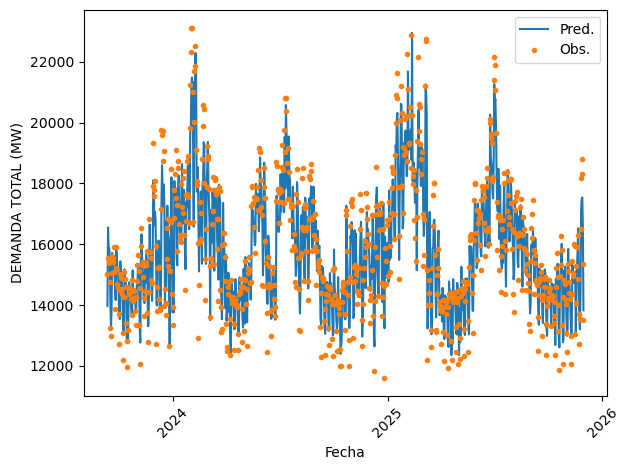

In [6]:
yy =pd.DataFrame(y_pred, index=y_test.index)

import matplotlib.dates as mdates
# 2. Plot the data
plt.plot(yy, label='Pred.')
plt.plot(y_test, '.', label='Obs.')

# 3. Format the x-axis to show only years
# Use YearLocator to place ticks at the start of each year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Use DateFormatter to format the labels as a 4-digit year (%Y)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 4. Optional: improve readability by rotating labels
plt.xticks(rotation=45)


plt.ylabel('DEMANDA TOTAL (MW)')
plt.xlabel('Fecha')
plt.legend(loc='best')
plt.tight_layout()

## Parte A - Ejercicios 

1. Representar la función de autocorrelación para la serie de residuos (en entrenamiento y validación). ¿Se asemejan los residuos a un error gaussiano? ¿Por qué? 
2. Analizar el peso de los coeficientes para cada uno de los 7 días anteriores considerados en el modelo de regresión lineal.
3. Modificar la cantidad de pasos o días observados y evaluar el desempeño del modelo en función de la cantidad de pasos. 
4. Reemplazar el ajuste lineal por un modelo de regresión no-lineal como Random Forest, XGBoost, u otro. Comparar el desempeño con el primer modelo.
5. Proponer un modelo que suma un pronóstico para 2 pasos adelante en el tiempo. ¿Se confirma que la confianza en la predicción decae a medida que se aleja el horizonte de pronóstico?
6. Realizar un pronóstico para 2 pasos adelante mediante recur 


## Parte B - Un ejemplo más completo con optimización de hiper-parámetros

Como lo adelantamos, buscamos establecer un mejor modelo para la predicción de la demanda eléctrica que no solo tenga en cuenta el pasado sino, también, los efectos de la temperatura, del tipo de jornada y el crecimiento de la demanda con los años. 


Prepararemos nuestro conjunto de datos tomando diferntes lags sobre el atributo `DEMANDA TOTAL`. Esta vez, constrtruiremos un `transformer` de `sklearn` para que dentro del preprocesado podamos variar la cantidad de pasos previos de `DEMANDA TOTAL` incluídos. Más adelante, veremos paquetes que extienden las funcionalidades de `sklearn` para trabajar con series de tiempo  como `skForecast` o `feature_engine.timeseries.forecasting` que incluye `LagFeatures()`, o `sktime.transformations.series.lag` con el método `Lag()` que automatiza la creación de atributos desplazados en el tiempo.   Además, incluíremos las variables explicativas adicionales mencionadas anteriormente.

### Automatiazción de la creación de atributos desplazados en el tiempo

Buscamos construir un `Transformer` de `sklearn` que nos permita incorporar en el preprocesado la creación de atributos con diferentes *lags* a partir de una serie de datos seleccionada. `sklearn` ofrece el `BaseEstimator` y el `TransformerMixin` que facilitan su creación 

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
class LagFeatures(TransformerMixin, BaseEstimator):
    def __init__(self, lags=1):
        self.lags = lags
    def fit(self, X, y=None):
        # Compute mean for handling potential NANs created by shifting
        self.X_mean = X.mean() 
        return self
    def transform(self, X):
        X_lagged = pd.DataFrame([])
        cols_to_lag = X.columns
        for col in cols_to_lag:
            for lag in range(1, self.lags+1):
                fill_value = self.X_mean[col]
                new_series = X[col].shift(lag, fill_value=fill_value)
                X_lagged = pd.concat([X_lagged, new_series], axis=1)
                X_lagged = X_lagged.rename(columns={X_lagged.columns[-1]:col + '_Lag_' + str(lag)})
        return X_lagged
        


Es importante notar que debemos rellenar (*imputar*) los valores faltantes que resultan del desplazamiento con el promedio de la columna. `sklearn` no permite transformar simultáneamente el *target* y recortar el conjunto de datos para comenzar la serie con valores de pasos anteriores en todos los *lags*. [Scikit-Learn Pipeline Transformers — The hassle of transforming target variables (Part 1)](https://medium.com/analytics-vidhya/scikit-learn-pipeline-transformers-the-hassle-of-transforming-target-variables-part-1-6dfb714e2aad)

Hacemos una prueba de cómo opera el método `fit_transform` de la clase recién creada

In [8]:
lag_transformer = LagFeatures()

lag_transformer.set_params(lags=7)
print(f'Lags: {lag_transformer.get_params()}')
X = lag_transformer.fit_transform(baseDiaria[['Dtotal']])

X = pd.concat([X, baseDiaria], axis=1)
X.head()

Lags: {'lags': 7}


,Dtotal_Lag_1,Dtotal_Lag_2,Dtotal_Lag_3,Dtotal_Lag_4,Dtotal_Lag_5,Dtotal_Lag_6,Dtotal_Lag_7,Dtotal,Jornada,Tmedia,Interval
2017-01-01 00:00:00,15403.947260,15403.947260,15403.947260,15403.947260,15403.94726,15403.94726,15403.94726,15693.686083,Domingo,31.30,0.0
2017-01-02 00:00:00,15693.686083,15403.947260,15403.947260,15403.947260,15403.94726,15403.94726,15403.94726,17209.160125,Hábiles,25.35,1.0
2017-01-03 00:00:00,17209.160125,15693.686083,15403.947260,15403.947260,15403.94726,15403.94726,15403.94726,18003.374875,Hábiles,25.45,2.0
2017-01-04 00:00:00,18003.374875,17209.160125,15693.686083,15403.947260,15403.94726,15403.94726,15403.94726,16951.457125,Hábiles,27.00,3.0
2017-01-05 00:00:00,16951.457125,18003.374875,17209.160125,15693.686083,15403.94726,15403.94726,15403.94726,15638.770458,Hábiles,21.90,4.0


### Variables dummies

Una situación frecuente, y presente en nuestro estudio de caso, es una en que debemos distinguir entre días hábiles, sábados, o domingos y feriados. Algunas veces, estas variables categóricas se denominan variables *dummies*. La manera habitual de tratar estos datos es asignar un 1 o un 0 para la presencia o ausencia de dicha característica: 

$$
y = \beta_0 + \beta_1 x_1 + \cdots + \beta_n X_n + \gamma_1 d_1 + \cdots \gamma_m d_m
$$

Así, las variables $x_i$ pueden referir a las distintas potencias de la `Tmedia` o los *lags*. Además, las variables $d_1, d_2, d_3$ representarían los días hábiles, sábados o domingos y feriados. Por ejemplo, un día hábil se codifica como $1, 0, 0$. Esto permite ajustar la serie completa de datos sin tener que partirla y ajustarla individualmente para cada tipo de día. Esta [codificación](https://scikit-learn.org/stable/modules/preprocessing.html) se logra fácilmente con la ayuda de clase `OneHotEncoder` de la biblioteca scikit-learn. 


### Transformaciones por columnas y procesamientos en pipelines 

Como es habitual encontrar datos que reúnen tanto valores numéricos como categóricos, la biblioteca scikit-learn ofrece herramientas para facilitar el [preprocesamiento](https://scikit-learn.org/stable/modules/preprocessing.html) como las transfromaciones por columnas `ColumnTransformer`. Asimismo, la biblioteca ofrece los `Pipeline` para [automatizar una cadena de procesos](https://scikit-learn.org/stable/modules/compose.html) que se repiten sobre distintos conjuntos se datos o, alternativamente, que se repiten para diferentes juegos de parámetros. La transformación por columnas nos permitirá combinar los desplazamientos en el tiempo, las potencias y las variables dummies... 


In [9]:
# Operations by columns
num_attribs = ['Tmedia']
cat_attribs = ['Jornada']
lag_attribs = ['Dtotal']
pass_attribs = ['Interval']

preprocessor = ColumnTransformer([
    ("num", PolynomialFeatures(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ("lag", LagFeatures(), lag_attribs),
    ("pass", 'passthrough', pass_attribs),
    # Default drop para columnas no especificadas
    # passthrough: Las columnas pasan al siguiente paso sin ninguna transformación
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()),
    ])


Vemos dos tipos de especiales de estimadores: *drop* y *passthrough*. El primero impide que las columnas listadas pasen al proceso siguiente. El otro permite que las columnas listadas pasen al paso siguiente sin ninguna trasnformación adicional.

Es importante conocer el nombre de los distintos parámetros de  manera de poder pasar valores para que las sucesivas corridas de prueba se puedan ejecutar con configuraciones diferentes. Para esto ejecutamos

In [10]:
print(full_pipeline.get_params())

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', PolynomialFeatures(), ['Tmedia']),
                                ('cat', OneHotEncoder(), ['Jornada']),
                                ('lag', LagFeatures(), ['Dtotal']),
                                ('pass', 'passthrough', ['Interval'])])), ('regressor', LinearRegression())], 'transform_input': None, 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', PolynomialFeatures(), ['Tmedia']),
                                ('cat', OneHotEncoder(), ['Jornada']),
                                ('lag', LagFeatures(), ['Dtotal']),
                                ('pass', 'passthrough', ['Interval'])]), 'regressor': LinearRegression(), 'preprocessor__force_int_remainder_cols': 'deprecated', 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', PolynomialF

Con la informacióna anterior, podemos establecer una configuración conveniente para el proceso de potenciación `PolynomialFeatures`

In [11]:
nlags = 7
degree = 2
full_pipeline.set_params(preprocessor__num__degree=degree,
                         preprocessor__num__include_bias=False,
                         preprocessor__cat__drop='first',
                         preprocessor__lag__lags=nlags
                        )

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Flujo de trabajo con validación cruzada (CV) y optimización de hiper-parámetros

Calibrar los parámetros de una función de predicción y probarla con los mismos datos es un error metodológico: un modelo que simplemente repetiría las etiquetas de las muestras que acaba de ver tendría una puntuación perfecta pero no predeciría nada útil todavía de los datos no vistos. Esta situación se llama sobreajuste. Para evitarlo, es una práctica común al realizar un experimento de aprendizaje automático (supervisado) mantener parte de los datos disponibles como un conjunto de prueba `X_test`, `y_test`. A continuación se muestra un diagrama de flujo de trabajo típico de [validación cruzada](https://scikit-learn.org/0.22/modules/cross_validation.html#time-series-split) en el entrenamiento de modelos. Los mejores parámetros pueden determinarse mediante técnicas de búsqueda en una grilla.

<img src="Figs/grid_search_workflow.png" width="300" alt="Diagrama de flujo del proceso de calibración/validación">


Recientemente, presentamos el procedimiento de validación cruzada con series temporales. En el enfoque básico, el conjunto de entrenamiento se divide en k+1 conjuntos más pequeños (existen otros enfoques pero generalmente siguen los mismos principios). Se entrena el modelo con los datos de la primeras carpetas y se valida con los datos en la carpeta inmediatamente siguiente. Luego, se repite para cada una de las k carpetas los siguientes pasos:

1. Se toma k=1
2. El modelo se entrena usando los k-folds primeros;
3. El modelo resultante se valida con los datos en el k+1 fold.
4. Mientras k es menor que la cantidad máxima de carpetas, se incremnta k y se retorna al paso 1.

La medida de rendimiento informada por la validación cruzada k veces es entonces el promedio de los valores calculados en el lazo. Este enfoque puede ser costoso desde el punto de vista computacional, pero no desperdicia demasiados datos (como es el caso cuando se fija un conjunto de validación arbitrario), lo cual es una gran ventaja en problemas como la inferencia inversa donde el número de muestras es muy pequeño.

Emplearemos al igual que en el caso anterior, el método `StratifiedShuffleSplit` para simplifcar el proceso de CV.



### Ajuste y evaluación de desempeño agregando variables exógenas

In [12]:
tscv = TimeSeriesSplit(n_splits=3)
# print(tscv)

train_rmse = np.array([])
test_rmse = np.array([])
for train, test in tscv.split(baseDiaria[nlags:]):
    X_train = baseDiaria.iloc[train,:]
    y_train = baseDiaria['Dtotal'].iloc[train]
    X_test = baseDiaria.iloc[test,:]
    y_test = baseDiaria['Dtotal'].iloc[test]
    # No hay leak, en el preprocesado se pierde la columna Dtotal 
    
    X_train_full = full_pipeline.fit(X_train, y_train)

    y_pred = full_pipeline.predict(X_train)
    train_rmse = np.append(train_rmse, root_mean_squared_error(y_train, y_pred))

    y_pred = full_pipeline.predict(X_test)
    test_rmse = np.append(test_rmse, root_mean_squared_error(y_test, y_pred))

print(f'Modelo con {nlags} lags y grado {degree}')
print('Train RMSE')
print(f'Mean: ({np.mean(train_rmse):.0f} +/- {np.std(train_rmse):.0f})MW')
print('Validation RMSE')
print(f'Mean: ({np.mean(test_rmse):.0f} +/- {np.std(test_rmse):.0f})MW')


Modelo con 7 lags y grado 2
Train RMSE
Mean: (549 +/- 26)MW
Validation RMSE
Mean: (691 +/- 101)MW


### Representación de la dependencia con la temperatura y el día de la semana

Vamos a representar el comportamiento de la demanda para cada tipo de jornada asumiendo un día fijo (el último de la serie). (Ya vimos que hay una tendencia al incremento de la demanda con los años de aproximadamente el 1%. Este tipo de gráficos nos permite investigar *¿Qué pasaría si..?*. Por ejemplo, podemos responder a qué pasaría si, bajo las mismas condiciones de demanda y temperatura, se trata de un día hábil o feriado.

Hábiles  media  17241.464472165004 

Sábado  media  15841.619715060342 

Domingo  media  15342.488974958876 



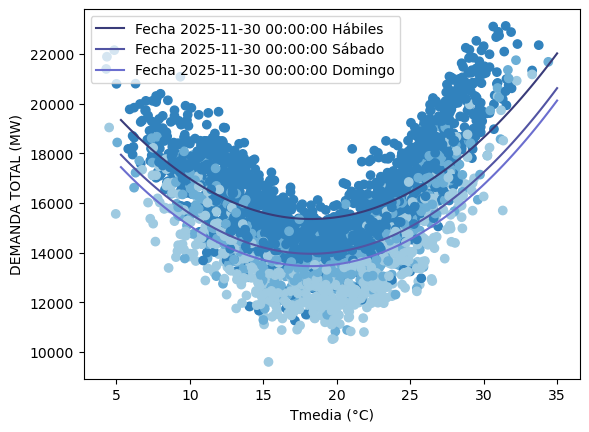

In [13]:
# Plot en función de jornada
# Fijo para una Fecha

jornadas_col = list(map(lambda x: plt.cm.tab20c.colors[['Hábiles', 'Sábado', 'Domingo'].index(x)], baseDiaria['Jornada']))
plt.scatter(baseDiaria['Tmedia'], baseDiaria['Dtotal'], c=jornadas_col)


for i, sdh in enumerate(['Hábiles', 'Sábado', 'Domingo']):

    fig_df = pd.DataFrame()
    for tmedia in np.linspace(5, 35, 100):
    
        fig_data = baseDiaria.iloc[-nlags-1:]
        fig_data.loc[:,'Jornada'] = sdh
        fig_data.loc[:,'Tmedia'] = tmedia  
        fig_df = pd.concat([fig_df, fig_data]) 
        
    fig_df_predict = full_pipeline.predict(fig_df)[nlags::nlags+1]
    print(sdh, ' media ', np.mean(fig_df_predict), '\n')
    plt.plot(fig_df['Tmedia'][nlags::nlags+1], fig_df_predict,
                color=plt.cm.tab20b.colors[i],
                label='Fecha {} {}'.format(baseDiaria.index[-1], sdh))

plt.xlabel('Tmedia (°C)')
plt.ylabel('DEMANDA TOTAL (MW)')
plt.legend(loc='best')
plt.show()

### Búsqueda de mejores hiper-parámetros sobre una grilla de valores 

Una vez que automatizamos la cadena de procesamiento, podemos ejecutarla para diferentes conjuntos de parámteros. En este caso, vamos a variar el grado máximo del ajuste polinómico (En el ejemplo anterior lo habíamos fijado en 2). La intención es encontrar el grado que produce el mejor puntaje en el proceso de validación cruzada. `GridSearchCV` repite la ejecución de la misma cadena de procesamiento para todos los valores que se le pasen como argumento en formato diccionario. Como la función busca el puntaje más alto, en el caso de que se evalúe el acuerdo mediante el RMSE, se debe pasar su inverso `neg_root_mean_squared_error`. 

En este caso particular, también le pasamos a `GridSearchCV` la estrategia de partición en los difrentes compartimientos ya que, por default emplea `k-fold`. 

#### Búsqueda de mejor grado para atributos polinomiales

In [14]:
tscv = TimeSeriesSplit(n_splits=3)
# print(tscv)

parameters = {'preprocessor__num__degree': np.arange(2,11).tolist()}

grid = GridSearchCV(full_pipeline, parameters,
                    scoring='neg_root_mean_squared_error',
                    cv=tscv, return_train_score=True)

# from sklearn.model_selection import RandomizedSearchCV
# grid = RandomizedSearchCV(full_pipeline, parameters, 
#                           scoring='neg_root_mean_squared_error',
#                           cv=tscv, return_train_score=True, random_state=0)

# When the Pipeline is printed out in a jupyter notebook an HTML
# representation of the estimator is displayed:
grid

,estimator,Pipeline(step...egression())])
,param_grid,"{'preprocessor__num__degree': [2, 3, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num', ...), ('cat', ...), ...]"


Luego de la búsqueda imprimimos el conjunto de mejores parámetros. El mejor resultado se obtiene con un polinomio de grado 6. Tmbién observamos que el RMSE es negativo.

In [15]:
# Calling ‘fit’ triggers the cross-validated search for
# the best hyper-parameters combination:             
grid.fit(baseDiaria, baseDiaria['Dtotal'])

print("Best params:")
print(grid.best_params_)

# The internal cross-validation scores obtained by those parameters is:

print(f"Internal CV score: {grid.best_score_:.3f}")

Best params:
{'preprocessor__num__degree': 6}
Internal CV score: -685.825


En general, los resultados de cada iteración se presentan en la variable `grid.results`. Nos enfocamos solamente en las columnas de puntaje para los datos de prueba y entrenamiento

In [16]:
# We can also introspect the top grid search results as a pandas dataframe:

grid_results = pd.DataFrame(grid.cv_results_)
# print('CV Results Column Names: ', grid_results.columns)

grid_results.rename(columns={'param_preprocessor__num__degree': 'degree'},
                    inplace=True)
grid_results[['mean_train_score',
              'mean_test_score']] = grid_results[['mean_train_score',
                                'mean_test_score']].apply(lambda x: x * (-1))
print(grid_results[['degree', 'mean_train_score',
                    'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

   degree  mean_train_score  mean_test_score  std_test_score  rank_test_score
4       6        520.513602       685.825011      100.184168                1
3       5        520.550183       686.099394      101.160742                2
2       4        520.793761       690.497507       97.736419                3
5       7        520.337191       692.797815      102.773352                4
6       8        520.379742       694.179234      110.812643                5
0       2        548.658604       742.962524       87.624187                6
1       3        542.934838       748.154348       98.178348                7
7       9        833.709096       944.272273       79.976310                8
8      10        833.778523       959.069033       86.968395                9


Asimismo, tomamos los resultados de la variable `grid.results` para mostrar como los datos de entreamiento siempre producen un menor RMSE respecto a los datos de prueba.

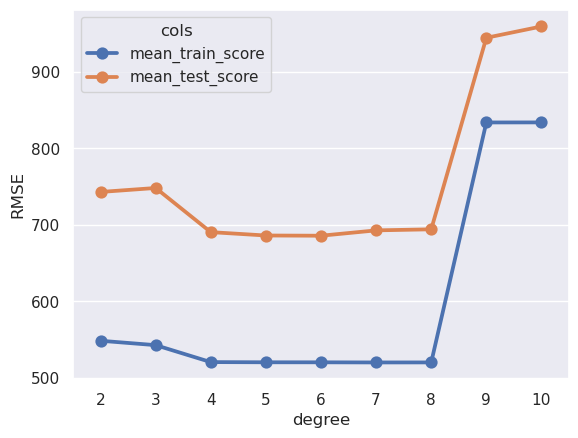

In [17]:
dfm = grid_results[['degree', 'mean_train_score',
                    'mean_test_score']].melt('degree',
                                             var_name='cols', value_name='RMSE')
# Apply the default theme
sns.set_theme()
sns.pointplot(
    data=dfm,
    x='degree', y='RMSE', hue='cols' 
)

plt.show()


Se aprecia el mínimo de RMSE en 6 pero un polinomio de grado 4 ya lo hace muy bien.

#### Búsqueda simultánea de mejor grado para atributos polinomiales y lags

Finalmente, vamos a variar smilutáneamente el orden del polígono en la temperatura media y el número de lags buscando el mejor estimador.

In [18]:
parameters = {'preprocessor__num__degree': np.arange(2,11).tolist(),
             'preprocessor__lag__lags': np.arange(5,15).tolist()}

grid = GridSearchCV(full_pipeline, parameters,
                    scoring='neg_root_mean_squared_error',
                    cv=tscv, return_train_score=True)

# Calling ‘fit’ triggers the cross-validated search for
# the best hyper-parameters combination:             
grid.fit(baseDiaria, baseDiaria['Dtotal'])

print("Best params:")
print(grid.best_params_)

# The internal cross-validation scores obtained by those parameters is:

print(f"Internal CV score: {grid.best_score_:.3f}")

Best params:
{'preprocessor__lag__lags': 12, 'preprocessor__num__degree': 6}
Internal CV score: -653.573


In [19]:
# We can also introspect the top grid search results as a pandas dataframe:

grid_results = pd.DataFrame(grid.cv_results_)
# print('CV Results Column Names: ', grid_results.columns)

grid_results.rename(columns={'param_preprocessor__num__degree': 'degree', 'param_preprocessor__lag__lags': 'lags'},
                    inplace=True)
grid_results[['mean_train_score',
              'mean_test_score']] = grid_results[['mean_train_score',
                                'mean_test_score']].apply(lambda x: x * (-1))
print(grid_results[['rank_test_score','degree', 'lags', 'mean_train_score',
                    'mean_test_score']].sort_values(by='rank_test_score'))


    rank_test_score  degree  lags  mean_train_score  mean_test_score
67                1       6    12        502.854972       653.572653
76                2       6    13        502.696037       653.929025
66                3       5    12        502.885310       654.082084
75                4       5    13        502.726151       654.459349
85                5       6    14        502.503931       654.526419
..              ...     ...   ...               ...              ...
26               86      10     7        833.778523       959.069033
16               87       9     6        859.415164       960.697012
17               88      10     6        859.477217       971.402467
7                89       9     5        933.436466      1043.413622
8                90      10     5        933.651972      1045.559770

[90 rows x 5 columns]


Vemos que duplicando la cantidad de lags (14) no mejora sustancialmente el desempeño en validación respecto al caso de considerar solo una semana de valores anteriores.

## Parte B - Ejercicios

1. Representar la función de autocorrelación para la serie de residuos (en entrenamiento y validación). ¿Se asemejan los residuos a un error gaussiano? ¿Por qué?  
2. Evaluar el desempeño del modelo que solo usa variables exógenas (no tiene en cuenta los valores recientes de la `DEMANDA TOTAL`).  
    a. ¿Se puede en este caso realizar mezcla de datos (shuffle)? ¿Se puede considerar este modelo como un *benchmark* para las técnicas de modelado de series temporales?  
    b. Representar la función de autocorrelación para la serie de residuos.  
    c. ¿Podría abordar a la serie de residuos como una serie temporal y buscar un modelo que mejor capture su cambio?  
3. ¿Se puede mejorar el desempeño si en lugar de considerar 3 variables dummies por tipo de día se tomaran 7 variables, una por cada día de la semana?  
4. Suponer que no se cuenta información de la temperatura media. Incorporar al modelo funciones trigonométricas para capturar los cambios de estaciones (y de consumo) a lo largo del año. ¿Cómo es el desempeño del modelo?


## Parte C - Simplificando las predicciones y pronósticos con Skforecast

### Ejemplo de pronóstico a 14 días

Vamos a dar un primer ejemplo sobre cómo emplear `Skforecast`. Tomamos los últimos 120 días de datos `DEMANDA TOTAL` y separamos los 14 días finales como conjunto de prueba para evaluar, posteriormente, la capacidad predictiva del modelo.

Train dates : 2025-08-03 00:00:00 --- 2025-11-16 00:00:00  (n=106)
Test dates  : 2025-11-17 00:00:00 --- 2025-11-30 00:00:00  (n=14)


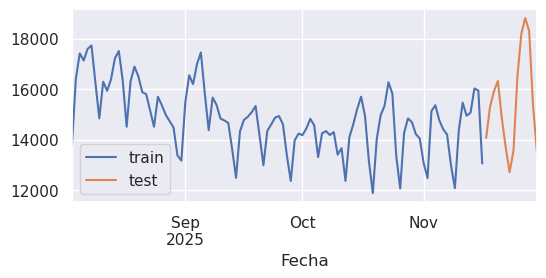

In [20]:
# Split data into train-test
# ==============================================================================
steps = 14
data_train = baseDiaria[-120:-steps].asfreq('D')
data_test  = baseDiaria[-steps:].asfreq('D')
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

from skforecast.plot import set_dark_theme
# set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Dtotal'].plot(ax=ax, label='train')
data_test['Dtotal'].plot(ax=ax, label='test')
ax.legend();

### Pronóstico recursivo multipaso

Normalmente, se busca el mejor acuerdo entre la variable en el tiempo $t$ y las predicciones del modelo entrenado con n valores que atrasan  (n lags) respecto a ese tiempo. Luego, se puede realimentar el valor predecido en la serie y pronosticar a la variable en el tiempo $t+1$ originando el *pronóstico recursivo multipaso*. Otra opción es el *pronóstico directo* en el que se entrenan diferentes modelos para ajustar los valores futuros de la variable en $t, t+1, \cdots$. Esta estrategia demanda mayor esfuerzo de cómputo ya que requiere entrenar tantos modelos como pasos futuros se planteen.     


![Diagrama de proceso de predicción recursiva de múltiples pasos para predecir 3 pasos en el futuro utilizando los últimos 4 rezagos de la serie como predictores.](Figs/diagram-recursive-mutistep-forecasting.png)

Diagrama de proceso de predicción recursiva de múltiples pasos para predecir 3 pasos en el futuro utilizando los últimos 4 lags de la serie como predictores.

La clase `ForecasterRecursive` crea y entrena un modelo de pronóstico recursivo utilizando de base un estimador de `sklearn`(por ejemplo, nosotros elegimos `LinearRegression()`). Para el ejemplo, planteamos una ventana de 7 lags. Esto significa que el modelo utiliza los 7 registros anteriores al instante que se busca predecir o pronosticar.

In [21]:
# Create and train forecaster
# ==============================================================================
from skforecast.recursive import ForecasterRecursive
forecaster = ForecasterRecursive(
                 estimator = LinearRegression(),
                 lags      = 7
             )

forecaster.fit(y=data_train['Dtotal'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Estimator: LinearRegression 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Series name: Dtotal 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2025-08-03 00:00:00'), Timestamp('2025-11-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False,
    'tol': 1e-06} 
fit_kwargs: {} 
Creation date: 2026-02-03 12:30:10 
Last fit date: 2026-02-03 12:30:10 
Skforecast version: 0.19.1 
Python version: 3.14.2 
Forecaster id: None

#### Ejemplo de predicción a 14 días

Una vez entrenado el modelo, se predicen los datos de prueba (con un horizonte de 14 días).

In [22]:
# Predictions
# ==============================================================================
steps = 14
predictions = forecaster.predict(steps=steps)
predictions

2025-11-17    13283.592795
2025-11-18    14676.269537
2025-11-19    14751.739719
2025-11-20    14560.325344
2025-11-21    15475.016235
2025-11-22    15651.774293
2025-11-23    14223.163597
2025-11-24    13627.013909
2025-11-25    14262.039375
2025-11-26    14495.115168
2025-11-27    14382.525336
2025-11-28    14929.299891
2025-11-29    15322.866899
2025-11-30    14688.133461
Freq: D, Name: pred, dtype: float64

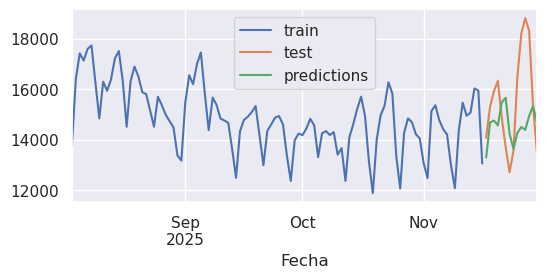

In [23]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Dtotal'].plot(ax=ax, label='train')
data_test['Dtotal'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Backtesting

El proceso de *backtesting* consiste en evaluar el rendimiento de un modelo predictivo aplicándolo retrospectivamente a datos históricos. Por lo tanto, se trata de un tipo especial de *validación cruzada* que se aplica al período o períodos anteriores.

El propósito del backtesting es evaluar la precisión y la eficacia de un modelo e identificar posibles problemas o áreas de mejora.

Se puede implementar *backtesting* utilizando una variedad de técnicas:
* Partición en datos de entrenamiento y prueba (*simple train-test split*)
* Backtesting without refit
  ![backtesting without refit](Figs/time-series-backtesting-forecasting-no-refit.gif)
* Backtesting with refit and increasing training size
  ![backtesting with refit and increasing training size](Figs/time-series-backtesting-forecasting-with-refit.gif)
* Backtesting with refit and fixed training size
  ![backtesting with refit and fixed training size](Figs/time-series-backtesting-forecasting-refit-fixed-train-size.gif)
* Backtesting with intermittent refit
  ![backtesting with intermittent refit](Figs/time-series-backtesting-forecasting-intermittent-refit.gif)
* Backtesting including gap, Backtesting with fold stride, otros

Fuente:  Skforecast: time series forecasting with Python, Machine Learning and Scikit-learn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) at https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

Un ejemplo de backtesting con refit consta de los siguientes pasos (asumimos como ejemplo steps=10):

1. Entrenar el modelo utilizando un conjunto de entrenamiento inicial, cuya longitud se especifica mediante `initial_train_size`.
2. Una vez entrenado el modelo, se utiliza para realizar predicciones para los siguientes 10 pasos (steps). Estas predicciones se guardan para su posterior evaluación.
3. Cuando `refit=True o int`, el tamaño del conjunto de entrenamiento aumenta agregando los 10 pasos anteriores (o 10 x n, donde n es el entero dado como argumento de `refit`), mientras que los siguientes 10 pasos se utilizan como datos de prueba.
4. Después de ampliar el conjunto de entrenamiento, el modelo se vuelve a entrenar utilizando los datos de entrenamiento actualizados y luego se utiliza para predecir los próximos 10 pasos.
5. Se repiten los pasos 3 y 4 hasta que se haya probado toda la serie.

### Implementación de backtesting con TimeSeriesFold

La clase `TimeSeriesFold` está diseñada para generar las particiones utilizadas en el proceso de backtesting para entrenar y evaluar el modelo. Al aprovechar sus diversos argumentos, ofrece una gran flexibilidad, lo que permite la simulación de escenarios como reajuste, no reajuste, origen variable y otros. El método `split` devuelve las posiciones de índice de las series temporales correspondientes a cada partición. Cuando se especifica `as_pandas=True`, la salida es un DataFrame con información detallada, incluyendo nombres de columnas descriptivos.

#### Ejemplo de evaluación por backtesting a 14 días con reajuste de parámetros

Proponemos evaluar el modelo de pronóstico a 14 días utilizando la técnica de backtesting. Particularmente, elegimos backtesting con reajuste intermitente que resulta en un esquema similar al visto con `TimeSeriesSplit` de `sklearn`

In [24]:
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 estimator       = LinearRegression(),
                 lags            = 7
             )

end_train = data_train.index[int(0.33 * len(data_train['Dtotal']))]
cv = TimeSeriesFold(
        steps                 = 14,
        initial_train_size    = end_train,
        refit                 = 2,
        fixed_train_size      = False,
        gap                   = 0,
        allow_incomplete_fold = True
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data_train['Dtotal'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )


Information of folds
--------------------
Number of observations used for initial training: 35
Number of observations used for backtesting: 71
    Number of folds: 6
    Number skipped folds: 0 
    Number of steps per fold: 14
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2025-08-03 00:00:00 -- 2025-09-06 00:00:00  (n=35)
    Validation: 2025-09-07 00:00:00 -- 2025-09-20 00:00:00  (n=14)
Fold: 1
    Training:   No training in this fold
    Validation: 2025-09-21 00:00:00 -- 2025-10-04 00:00:00  (n=14)
Fold: 2
    Training:   2025-08-03 00:00:00 -- 2025-10-04 00:00:00  (n=63)
    Validation: 2025-10-05 00:00:00 -- 2025-10-18 00:00:00  (n=14)
Fold: 3
    Training:   No training in this fold
    Validation: 2025-10-19 00:00:00 -- 2025-11-01 00:00:00  (n=14)
Fold: 4
    Training:   2025-08-03 00:00:00 -- 2025-11-01 00:00:00  (n=91)
    Validation: 2025-11-02 00:00:00 -- 

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
# Backtest error and predictions
# ==============================================================================
print(f'RMSE: {np.sqrt(metric['mean_squared_error'][0]):.0f}MW')
predictions.head()

RMSE: 1118MW


,fold,pred
2025-09-07,0,14607.858336
2025-09-08,0,15099.365061
2025-09-09,0,15478.416890
2025-09-10,0,15345.981863
2025-09-11,0,15942.786846


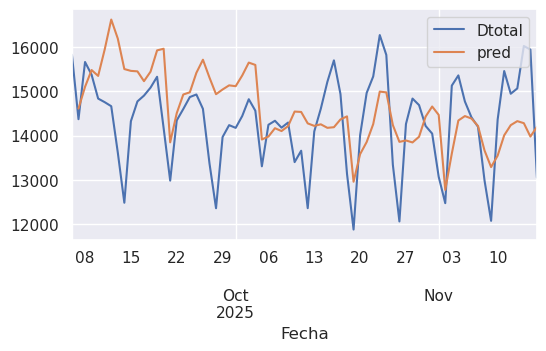

In [26]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.loc[end_train:, 'Dtotal'].plot(ax=ax)
predictions['pred'].plot(ax=ax)
ax.legend()
plt.show();

### Ajustes de hiper-parámetros

`Skforecast` ofrece varias estrategias de búsqueda para encontrar la mejor combinación de hiperparámetros y lags. En este caso, se utiliza la función `grid_search_forecaster`, que compara los resultados obtenidos con cada combinación de hiperparámetros y lags e identifica la mejor.

La búsqueda sobre una grilla evalúa una lista exhaustiva de combinaciones de hiperparámetros y lags para encontrar la configuración óptima de un modelo de pronóstico. Para realizar una búsqueda sobre una grilla con la biblioteca `skforecast`, se necesitan dos cuadrículas: una con diferentes lags (lags_grid) y otra con los hiperparámetros (param_grid).

El proceso de búsqueda en la grilla implica los siguientes pasos:

1. `grid_search_forecaster` reemplaza el argumento lags con la primera opción que aparece en lags_grid
2. La función valida todas las combinaciones de hiperparámetros presentados en param_grid mediante *backtesting* o *validación de un paso adelante*.
3. La función repite estos dos pasos hasta que haya evaluado todas las combinaciones posibles de lags e hiperparámetros.
4. Si `return_best = True`, el pronosticador original se entrena con los mejores lags y la mejor configuración de hiperparámetros encontrados durante el proceso de búsqueda de la cuadrícula.

### Ejemplo de ajuste de hiper-parámetros incorporando variables exógenas

Traemos aquí nuestro preprocesado por columnas pero ahora sin incluir las variables con *lags*. De las variables *lags* se encarga la  clase `ForecasterRecursive`.

In [27]:
X = baseDiaria.asfreq('D')
# X['Jornada'] = pd.Categorical(X['Jornada']).codes
X_test = X[-steps:]
X = X[:-steps]
# Operations by columns
# La columna Dtotal ahora se maneja dentro del Forecaster
num_attribs = ['Tmedia']
cat_attribs = ['Jornada']
pass_attribs = ['Interval']

preprocessor_exog = ColumnTransformer([
    ("num", PolynomialFeatures(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ("pass", 'passthrough', pass_attribs),
    # Default drop para columnas no especificadas
],remainder='passthrough', verbose_feature_names_out=False)

preprocessor_exog.set_params(num__degree=2,
                            num__include_bias=False,
                            cat__drop='first')



,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,degree,2
,interaction_only,False
,include_bias,False


Aquí definimos `forecaster`. Vemos que necesita especifcar por separado al preprocesador de las variables exógenas. 

In [28]:
# Backtesting forecaster
# ==============================================================================

forecaster = ForecasterRecursive(estimator = LinearRegression(),
                                 lags = 7,
                                 transformer_exog = preprocessor_exog
                                )
forecaster

=================== 
ForecasterRecursive 
=================== 
Estimator: LinearRegression 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Series name: None 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('num', PolynomialFeatures(include_bias=False),
                                 ['Tmedia']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Jornada']),
                                ('pass', 'passthrough', ['Interval'])],
                  verbose_feature_names_out=False) 
Weight function included: False 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False,
    'tol': 1e-06} 
fit_kwargs: {} 
Creation date: 2026-02-03 12:30:11 
Last fit date: None 
Skforecast version: 0.19.1 
Python version: 3.14.2 
Forecaster id: None

El método `create_train_X_y` nos permite inspeccionar cómo lucen los atributos luego de agregar los *lags* y el preprocesado de las variables exógeneas, justo antes de entrar al estimador.

In [29]:
# Inspect training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = X['Dtotal'],
                       exog = X[['Tmedia', 'Jornada', 'Interval']]
                   )
X_train.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Tmedia,Tmedia^2,Jornada_Hábiles,Jornada_Sábado,Interval
Fecha,,,,,,,,,,,,
2017-01-08,16580.500958,15754.520792,15638.770458,16951.457125,18003.374875,17209.160125,15693.686083,25.90,670.8100,0.0,0.0,7.0
2017-01-09,14579.215458,16580.500958,15754.520792,15638.770458,16951.457125,18003.374875,17209.160125,25.55,652.8025,1.0,0.0,8.0
2017-01-10,16774.861125,14579.215458,16580.500958,15754.520792,15638.770458,16951.457125,18003.374875,22.40,501.7600,1.0,0.0,9.0
2017-01-11,15137.660792,16774.861125,14579.215458,16580.500958,15754.520792,15638.770458,16951.457125,25.60,655.3600,1.0,0.0,10.0


En lo siguiente, definimos un esquema de validación con reajuste (*refit*) intermitente. Cada bloque de entrenamiento contiene un 20% más de los datos. Definimos `initial_train_size` como la cantidad de pasos igual al 20% de los datos. Como solo pronosticamos un paso adelante (`steps=1`) y re-entrenamos cada `initial_train_size` pasos (steps), esto conduce a un esquema de *backtesting* con 20%, 40%, 60% y 80% de datos de entrenamiento, sucesivamente.

El esquema de *backtesting* descrito en el párrafo anterior se emplea en la búsqueda de mejores hiper-parámetros mediante la función ~ grid_search_forecaster`. Aquí, también debemos especificar por separado las variables endógenas y exógenas. Se observa que se puede pasar un lista de *lags* para evaluar en la grilla. Asimismo, admite un diccionario con lista de parámetros del estimador. En principio, no parece funcionar el diccionario con la lista de hiper_parámetros para el preprocesador.

In [30]:
initial_train_size = int(0.2 * len(X['Dtotal']))
end_train = X.index[initial_train_size]
cv = TimeSeriesFold(
        steps                 = 1,
        initial_train_size    = end_train,
        refit                 = initial_train_size,
        fixed_train_size      = False,
        gap                   = 0,
        allow_incomplete_fold = True
     )

# Lags used as predictors
lags_grid = [6,7,8]

# Estimator hyperparameters
# param_grid = {'preprocessor_exog__num__degree': np.arange(2,11).tolist()}
param_grid = {'fit_intercept': [True]}

df_results=pd.DataFrame([])
for i, degree in enumerate([4,5,6,7]):

    print(f"Grid search for degree: {degree}")
    print("-------------------------")
    
    preprocessor_exog.set_params(num__degree=degree,
                            num__include_bias=False,
                            cat__drop='first')


    results = grid_search_forecaster(forecaster = forecaster,
                                     y = X['Dtotal'],
                                     cv = cv,
                                     param_grid = param_grid,
                                     metric = 'mean_squared_error',
                                     exog = X[['Tmedia', 'Jornada', 'Interval']],
                                     lags_grid = lags_grid,
                                     return_best = False,
                                     n_jobs = 'auto',
                                     verbose = False,
                                     show_progress = True
          )
    results['degree']=degree
    df_results = pd.concat([df_results, results])


Grid search for degree: 4
-------------------------


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Grid search for degree: 5
-------------------------


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Grid search for degree: 6
-------------------------


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

Grid search for degree: 7
-------------------------


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
df_results['RMSE'] = np.sqrt(df_results['mean_squared_error'])
df_results.drop(columns=['lags_label', 'params'], inplace=True)
df_results.sort_values(by='mean_squared_error')

,lags,mean_squared_error,fit_intercept,degree,RMSE
0,"[1, 2, 3, 4, 5, 6, 7, 8]",423421.800508,True,6,650.708691
0,"[1, 2, 3, 4, 5, 6, 7, 8]",424040.475781,True,5,651.183903
0,"[1, 2, 3, 4, 5, 6, 7, 8]",424818.215464,True,4,651.780803
1,"[1, 2, 3, 4, 5, 6, 7]",427592.106399,True,6,653.905273
1,"[1, 2, 3, 4, 5, 6, 7]",427915.710182,True,5,654.152666
1,"[1, 2, 3, 4, 5, 6, 7]",428914.048152,True,4,654.915298
2,"[1, 2, 3, 4, 5, 6]",429271.469534,True,6,655.188118
2,"[1, 2, 3, 4, 5, 6]",429901.394389,True,5,655.668662
2,"[1, 2, 3, 4, 5, 6]",430702.457845,True,4,656.279253
0,"[1, 2, 3, 4, 5, 6, 7, 8]",433445.185789,True,7,658.365541


Vemos que, nuevamente, el mejor ajuste se logra con un polinomio de grado 6. El RMSE es similar a los obtenidos anteriorimente. Entendemos que aquí es algo más bajo (mejor) para igual grado y número de lags ya que no se realice imputación con la media...

#### Final model



In [32]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
preprocessor_exog.set_params(num__degree=6,
                            num__include_bias=False,
                            cat__drop='first')
forecaster.set_lags(8)
forecaster.fit(y=X['Dtotal'], exog=X[['Tmedia', 'Jornada', 'Interval']])

In [33]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=X_test[['Tmedia', 'Jornada', 'Interval']])

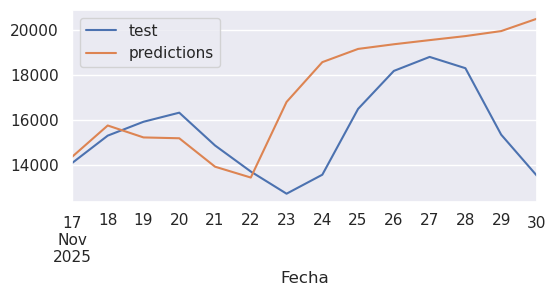

In [34]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
X_test['Dtotal'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Parte C - Ejercicios

1. Realizar el ajuste de hiper-parámetros variando los *lags* entre 5 y 15, y el grado de los atributos polinómicos entre 2 y 8. Emplear el método `grid_search_forecaster` con un esquema de validación por *backtesting* sin reajuste (*without refit*) para reducir el tiempo de búsqueda. Obtener el modelo final con los mejores parámetros. Evaluar por backtesting a 14 días con reajuste de parámetros.
